<a href="https://colab.research.google.com/github/edsonpolucena/mineracao-de-dados/blob/main/trabalho-03-Exploracao_Dados/notebooks/Avaliacao-N3-mineracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alunos: Edson Borges Polucena, Wuelliton Christian dos Santos

1) Retome a resolução do exercício 1 realizado na N2-P2, em que entre seis conjuntos de dados
(séries temporais) do https://dadosabertos.bcb.gov.br foi escolhido um. Utilize tal dataset e aplique
os modelos ARIMA e SARIMA, bem como a demonstração dos passos dessa aplicação (3,0).

Baixando série SGS 29265…

=== Comprometimento da renda ===
Slope (regressão linear): 0.3317 pp/ano
Mann-Kendall τ / p-valor : 0.555 / 0.000
Tendência: CRESCENTE


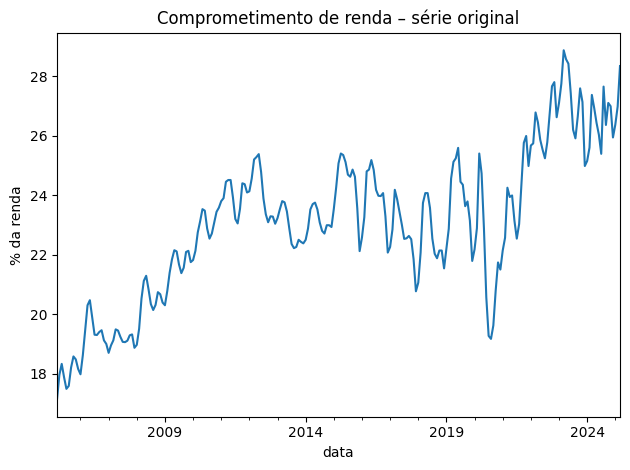

/tmp/ipython-input-1-1230481032.py:95: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie_m = serie.resample("M").mean()



ADF p-valor (série mensal): 0.5529
 → Série não estacionária. Aplicando d=1...

Ajustando ARIMA(1,1,1)...
                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                  241
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -232.151
Date:                Wed, 25 Jun 2025   AIC                            470.303
Time:                        22:22:30   BIC                            480.744
Sample:                    03-31-2005   HQIC                           474.510
                         - 03-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1880      0.154      1.221      0.222      -0.114       0.490
ma.L1          0.1575   

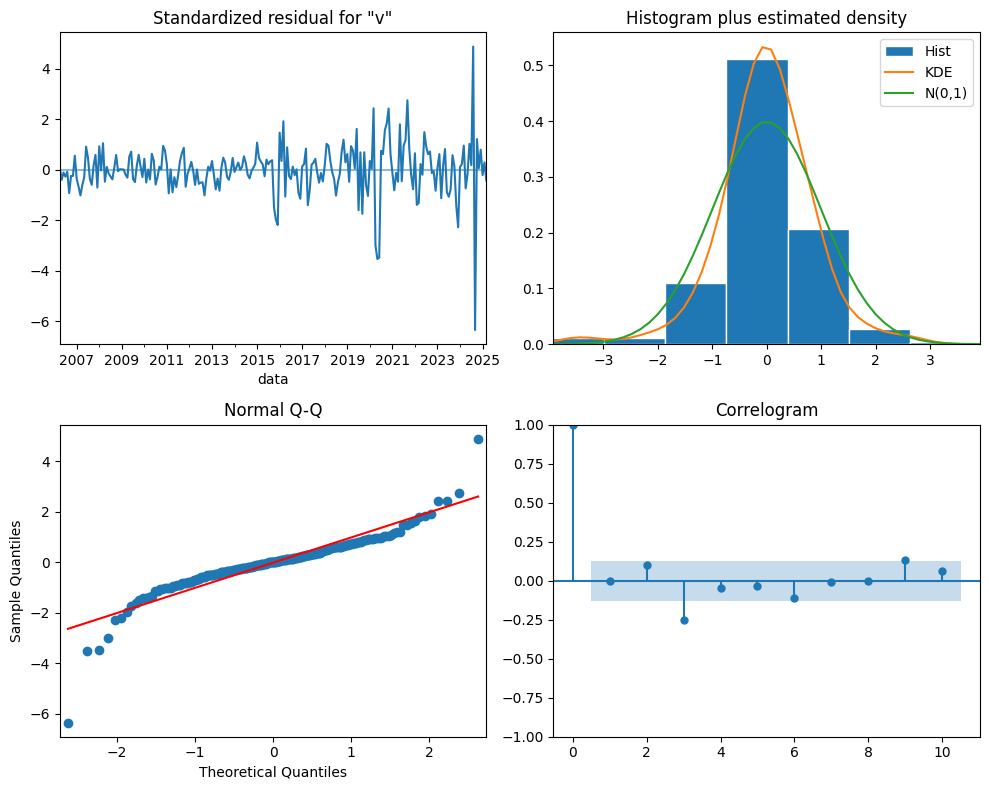


PNG exportados em: outputs/


In [ ]:
import os
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.linear_model import LinearRegression
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------------- Configurações ----------------
SERIES_ID    = 29265        # Comprometimento de renda – sem ajuste
DATA_INICIAL = "01/03/2005"
HOJE         = datetime.today().strftime("%d/%m/%Y")
OUT_DIR      = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Funções utilitárias ----------------
def _fetch_chunk(series_id: int, start: str, end: str) -> pd.DataFrame:
    url = (
        f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_id}/dados"
        f"?formato=json&dataInicial={start}&dataFinal={end}"
    )
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    # Ler JSON do texto diretamente para DataFrame
    df = pd.read_json(pd.io.common.StringIO(r.text), dtype={"valor": "float"})
    df["data"] = pd.to_datetime(df["data"], format="%d/%m/%Y")
    return df


def fetch_series(series_id: int, start: str, end: str) -> pd.DataFrame:
    start_dt = datetime.strptime(start, "%d/%m/%Y")
    end_dt   = datetime.strptime(end,   "%d/%m/%Y")
    dfs, chunk = [], start_dt
    while chunk <= end_dt:
        try:
            end_chunk = chunk.replace(year=chunk.year + 9)
        except ValueError:
            end_chunk = chunk + timedelta(days=365*9+2)
        if end_chunk > end_dt:
            end_chunk = end_dt

        dfs.append(_fetch_chunk(
            series_id,
            chunk.strftime("%d/%m/%Y"),
            end_chunk.strftime("%d/%m/%Y"),
        ))
        chunk = end_chunk + timedelta(days=1)

    return pd.concat(dfs).sort_values("data").reset_index(drop=True)


def mann_kendall(series: pd.Series):
    tau, p = kendalltau(range(len(series)), series)
    return tau, p


def linear_slope(series: pd.Series):
    x = (series.index.astype(int) // 10**9).values.reshape(-1, 1)
    y = series.values.reshape(-1, 1)
    coef = LinearRegression().fit(x, y).coef_[0][0]
    return coef * 60 * 60 * 24 * 365  # anualiza

# ---------------- Pipeline principal ----------------
def main():
    print("Baixando série SGS 29265…")
    df = fetch_series(SERIES_ID, DATA_INICIAL, HOJE)

    df = df.groupby("data", as_index=False)["valor"].mean()

    serie = df.set_index("data")["valor"]
    slope = linear_slope(serie)
    tau, p = mann_kendall(serie)
    tendencia = (
        "CRESCENTE" if slope > 0 and p < 0.05
        else "DECRESCENTE" if slope < 0 and p < 0.05
        else "ESTÁVEL"
    )

    print("\n=== Comprometimento da renda ===")
    print(f"Slope (regressão linear): {slope:.4f} pp/ano")
    print(f"Mann-Kendall τ / p-valor : {tau:.3f} / {p:.3f}")
    print(f"Tendência: {tendencia}")

    serie.plot(title="Comprometimento de renda – série original", ylabel="% da renda")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "trend_original.png"))
    plt.show()

    serie_m = serie.resample("M").mean()

    adf_p = adfuller(serie_m.dropna())[1]
    print(f"\nADF p-valor (série mensal): {adf_p:.4f}")
    if adf_p > 0.05:
        print(" → Série não estacionária. Aplicando d=1...")
        serie_diff = serie_m.diff().dropna()
    else:
        print(" → Série estacionária.")
        serie_diff = serie_m.dropna()

    #plot_acf(serie_diff, title="ACF da série diferenciada"); plt.show()
    #plot_pacf(serie_diff, title="PACF da série diferenciada"); plt.show()

    # 8) Ajuste ARIMA e SARIMA
    print("\nAjustando ARIMA(1,1,1)...")
    arima = ARIMA(serie_m, order=(1,1,1)).fit()
    print(arima.summary())

    print("\nAjustando SARIMA(1,1,1)(1,1,1)[12]...")
    sarima = SARIMAX(serie_m, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
    print(sarima.summary())

    # 9) Comparar AIC/BIC
    print(f"\nARIMA AIC:  {arima.aic:.2f}  |  BIC: {arima.bic:.2f}")
    print(f"SARIMA AIC: {sarima.aic:.2f}  |  BIC: {sarima.bic:.2f}")

    # 10) Diagnóstico de resíduos SARIMA
    sarima.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "sarima_diagnostics.png"))
    plt.show()

    print(f"\nPNG exportados em: {OUT_DIR}/")

if __name__ == "__main__":
    main()


1. Crescimento ao longo do tempo
Inclinação (slope): 0,3317 p.p./ano

A regressão linear sobre toda a série estima que, em média, a parcela da renda comprometida com dívidas cresce 0,33 pontos percentuais por ano.

Mann–Kendall τ = 0,555 (p-valor ≈ 0,000)

τ positivo e p-valor < 0,05 indicam uma tendência crescente estatisticamente significativa.

2. Estacionariedade da série
Teste ADF p-valor = 0,5529

Como p > 0,05, a hipótese de estacionariedade é rejeitada: a série possui tendência ou variância não constante no nível.

Diferenciação (d = 1)

Aplicada uma vez para remover essa tendência e tornar os dados adequados ao modelo ARIMA/SARIMA.

3. Ajuste do modelo ARIMA(1,1,1)
Sumário-chave

ar.L1 = 0,1880 (p-valor 0,222): componente autorregressivo de 1º ordem não significativo.

ma.L1 = 0,1575 (p-valor 0,300): componente de média móvel de 1º ordem não significativo.

σ² = 0,4050 (p-valor < 0,001): variância do ruído.

Métrica	Valor
AIC	470,30
BIC	480,74

Resíduos:

Ljung–Box Q(1) p-valor = 0,89 → sem autocorrelação remanescente.

Jarque–Bera p-valor = 0,00 → resíduos não seguem distribuição normal (curtose alta).

Heterocedasticidade p-valor = 0,00 → variância dos resíduos não é constante.

4. Ajuste do modelo SARIMA(1,1,1)(1,1,1)[12]
Sumário-chave

ar.L1 = 0,3601 (p-valor 0,034): componente autorregressivo não sazonal significativo.

ma.S.L12 = –0,6175 (p-valor < 0,001): componente de média móvel sazonal (lag 12) altamente significativo, captura os ciclos anuais.

σ² = 0,1882 (p-valor < 0,001): variância do ruído, menor que no ARIMA.

Métrica	Valor
AIC	282,61
BIC	299,75

Resíduos:

Ljung–Box Q(1) p-valor = 0,99 → sem autocorrelação remanescente.

Jarque–Bera p-valor = 0,00 → resíduos não normais (curtose muito elevada).

Heterocedasticidade p-valor = 0,00 → variância não constante.

5. Comparação e conclusão
Melhor ajuste: SARIMA apresenta AIC/BIC bem menores que o ARIMA, mostrando que o componente sazonal é essencial para explicar os padrões anuais da série.

Resíduos “brancos” (sem autocorrelação) em ambos os modelos, mas violam normalidade e homocedasticidade → sugere considerar, em etapas posteriores, modelos para variância condicional (por ex. GARCH) ou ajustes de outliers.

Uso prático: para previsão de curto e médio prazo dessa série mensal, o modelo SARIMA(1,1,1)(1,1,1)[12] será mais confiável, pois incorpora tanto a dinâmica de curto prazo quanto o ciclo sazonal anual.

2) Sobre Mineração de Texto, oito técnicas foram apresentadas, das quais, duas foram
exemplificadas em aula. Apresente três exemplos, incluindo uma das técnicas mostrada em aula.
Utilize textos aleatórios copiados/baixados de páginas de internet, redes sociais, etc., como input
para os exemplos (4,0).

2.1 TF–IDF + Similaridade de Cosseno
(Text similarity)

Este código mede o quão parecidas são as duas frases, transformando-as em vetores num espaço TF–IDF e usando o cosseno do ângulo entre eles. Também lista as palavras que estão presentes em ambas.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# 1) Definição das duas frases
sentence1 = "O risoto de camarão estava muito saboroso e bem temperado."
sentence2 = "Gostei do tempero do risoto, mas o camarão veio pouco cozido."

docs = [sentence1, sentence2]

# 2) Vetorização TF–IDF
tfidf_vectorizer = TfidfVectorizer()
sparse_matrix = tfidf_vectorizer.fit_transform(docs)

# 3) Montagem do DataFrame termo-documento para extrair palavras
df = pd.DataFrame(
    sparse_matrix.todense(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=['sentence1', 'sentence2']
)

# 4) Cálculo da similaridade de cosseno
similarity_score = cosine_similarity(df, df)[0, 1]

# 5) Identificação das palavras em comum
#    palavras com valor > 0 em ambas as linhas
zero_counts = df.isin([0]).sum(axis=0)
match_words = zero_counts[zero_counts.values == 0].keys()

# 6) Impressão apenas dos resultados desejados
print(f"Similaridade Coseno: {similarity_score:.2f}")
print("Palavras em comum:", list(match_words))



Similaridade Coseno: 0.12
Palavras em comum: ['camarão', 'risoto']


2.2 Tokenização e Remoção de Stop-Words
(Term/Word frequency analysis)

Esse código pré-processa um texto, dividindo-o em palavras (tokens) e removendo termos muito comuns (stop-words), deixando apenas palavras com maior potencial informativo.




In [ ]:
import re
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

texto = "O aprendizado de máquina facilita tarefas, mas exige dados de qualidade!"

# 2) Tokenizar
tokens = re.findall(r"\b[À-ÿ\w]+\b", texto.lower())

# 3) Remover stop-words corretamente
sw = set(stopwords.words('portuguese'))
tokens_filtrados = [t for t in tokens if t not in sw]

print("Tokens originais:", tokens)
print("Tokens filtrados:", tokens_filtrados)



Tokens originais: ['o', 'aprendizado', 'de', 'máquina', 'facilita', 'tarefas', 'mas', 'exige', 'dados', 'de', 'qualidade']
Tokens filtrados: ['aprendizado', 'máquina', 'facilita', 'tarefas', 'exige', 'dados', 'qualidade']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2.3 Topic Modeling com LDA (Topic Recognition)

Este código identifica automaticamente dois tópicos potenciais em uma coleção de textos e, para cada tópico, exibe as palavras mais representativas — tudo isso sem qualquer rotulação manual dos documentos.












In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# === Exemplo de pequenos “documentos” já tokenizados em strings ===
docs = [
    "inteligência artificial aprendizado máquina",
    "dados qualidade limpeza processamento",
    "modelo treinamento validacao métricas"
]

# 1) Converter para bag-of-words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

# 2) Treinar LDA com 2 tópicos
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(X)

# 3) Imprimir os tópicos
n_top_words = 4
for topic_idx, topic in enumerate(lda.components_):
    top_terms = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Tópico {topic_idx+1}: {', '.join(top_terms)}")


Tópico 1: aprendizado, máquina, inteligência, artificial
Tópico 2: processamento, qualidade, dados, limpeza


3) Apresente um exemplo de Web Scraping, em que o resultado da raspagem seja armazenado em
formato csv ou txt para posterior Mineração de Texto (3,0).

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv

BASE_URL = "https://www.catolicasc.org.br"

def scrape_course_names():
    resp = requests.get(BASE_URL)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, "html.parser")
    course_names = []

    # Seleciona cada slide do carrossel
    for slide in soup.select("div.slides-container .slide"):
        # Dentro de cada item, o nome do curso está no <h3><a>...</a></h3>
        title_tag = slide.select_one("div.description h3 a")
        if title_tag:
            name = title_tag.get_text(strip=True)
            course_names.append(name)

    # Remove duplicatas
    return list(dict.fromkeys(course_names))

if __name__ == "__main__":
    courses = scrape_course_names()

    # Mostrar no console
    for c in courses:
        print(c)

    # Salvar em arquivo TXT
    with open("cursos_catolicaSC.txt", "w", encoding="utf-8") as txtfile:
        for c in courses:
            txtfile.write(c + "\n")
    print("Cursos salvos em cursos_catolicaSC.txt")

DESIGN
DIREITO
PEDAGOGIA
GESTÃO E EMPREENDEDORISMO
ENFERMAGEM
ENGENHARIA DE SOFTWARE
Cursos salvos em cursos_catolicaSC.txt
